In [2]:
# SIR model example for python 2.7, working to get it update to python 3.10
# Marisa Eisenberg (marisae@umich.edu)
# Yu-Han Kao (kaoyh@umich.edu) -7-9-17
# Qianxin (Carl) Gan (<hidden>@berkeley.edu)

#### Import all the packages ####
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import copy

from scipy.integrate import odeint as ode
from scipy.stats import poisson
from scipy.stats import norm

In [3]:
# model equations for the scaled SIR model for python 2.7

def model(ini, time_step, params):
    Y = np.zeros(3) #column vector for the state variables
    X = ini
    mu = 0
    beta = params[0]
    gamma = params[1]

    Y[0] = mu - beta*X[0]*X[1] - mu*X[0] #S
    Y[1] = beta*X[0]*X[1] - gamma*X[1] - mu*X[1] #I
    Y[2] = gamma*X[1] - mu*X[2] #R

    return Y

def x0fcn(params, data):
    S0 = 1.0 - (data[0]/params[2])
    I0 = data[0]/params[2]
    R0 = 0.0
    X0 = [S0, I0, R0]

    return X0


def yfcn(res, params):
    return res[:,1]*params[2]

In [4]:
# Simplified FIM (Fisher information matirx) function for the SIR model

def minifisher (times, params, data, delta = 0.001):
    #params = np.array(params)
    listX = []
    params_1 = np.array(params)
    params_2 = np.array(params)
    for i in range(len(params)):
        params_1[i] = params[i] * (1 + delta)
        params_2[i]= params[i] * (1 - delta)

        res_1 = ode(model, x0fcn(params_1, data), times, args=(params_1,))
        res_2 = ode(model, x0fcn(params_2, data), times, args=(params_2,))
        subX = (yfcn(res_1, params_1) - yfcn(res_2, params_2)) / (2 * delta * params[i])
        listX.append(subX.tolist())
    X = np.matrix(listX)
    FIM = np.dot(X, X.transpose())
    return FIM

In [5]:
# cost function for the SIR model for python 2.7

def NLL(params, data, times): #negative log likelihood
    params = np.abs(params)
    data = np.array(data)
    res = ode(model, x0fcn(params, data), times, args=(params,))
    y = yfcn(res, params)
    nll = sum(y) - sum(data * np.log(y))
    # note this is a slightly shortened version--there's an additive constant term missing but it 
    # makes calculation faster and won't alter the threshold. Alternatively, can do:
    # nll = -sum(np.log(poisson.pmf(np.round(data),np.round(y)))) # the round is b/c Poisson is for (integer) count data
    # this can also barf if data and y are too far apart because the dpois will be ~0, which makes the log angry

    # ML using normally distributed measurement error (least squares)
    # nll = -sum(np.log(norm.pdf(data,y,0.1*np.mean(data)))) # example WLS assuming sigma = 0.1*mean(data)
    # nll = sum((y - data)**2)  # alternatively can do OLS but note this will mess with the thresholds 
    #                             for the profile! This version of OLS is off by a scaling factor from
    #                             actual LL units.
    return nll

In [6]:
# Profile Likelihood Generator

# Input definitions
# params = starting parameters (all, including the one to be profiled)
# profparam = index within params for the parameter to be profiled
#   ---reminder to make this allow you to pass the name instead later on
# costfun = cost function for the model - should include params, times, and data as arguments.
#   Note costfun doesn't need to be specially set up for fixing the profiled parameter, 
#   it's just the regular function you would use to estimate all the parameters
#   (it will get reworked to fix one of them inside ProfLike)
# times, data = data set (times & values, or whatever makes sense)
#   ---possibly change this so it's included in costfun and not a separate set of inputs? Hmm.
# perrange = the percent/fraction range to profile the parameter over (default is 0.5)
# numpoints = number of points to profile at in each direction (default is 10)

# Output
# A list with:
#   - profparvals: the values of the profiled parameter that were used
#   - fnvals: the cost function value at each profiled parameter value
#   - convergence: the convergence value at each profiled parameter value
#   - paramestvals: the estimates of the other parameters at each profiled parameter value

def proflike(params, profindex, cost_func, times, data, perrange = 0.5, numpoints = 10):
    profrangedown = np.linspace(params[profindex], params[profindex] * (1 - perrange), numpoints).tolist()
    profrangeup = np.linspace(params[profindex], params[profindex] * (1 + perrange), numpoints).tolist()[1:] #skip the duplicated values
    profrange = [profrangedown, profrangeup]
    currvals = []
    currparams = []
    currflags = []

    def profcost(fit_params, profparam, profindex, data, times, cost_func):
        paramstest = fit_params.tolist()
        paramstest.insert(profindex, profparam)
        return cost_func (paramstest, data, times)

    fit_params = params.tolist() #make a copy of params so we won't change the origianl list
    fit_params.pop(profindex)
    print('Starting profile...')
    for i in range(len(profrange)):
        for j in profrange[i]:
            print(i, j)
            optimizer = optimize.minimize(profcost, fit_params, args=(j, profindex, data, times, cost_func), method='Nelder-Mead')
            fit_params = np.abs(optimizer.x).tolist() #save current fitted params as starting values for next round
            #print optimizer.fun
            currvals.append(optimizer.fun)
            currflags.append(optimizer.success)
            currparams.append(np.abs(optimizer.x).tolist())

    # structure the return output
    profrangedown.reverse()
    out_profparam = profrangedown + profrangeup
    temp_ind = list(range(len(profrangedown)))
    temp_ind.reverse()
    out_params = [currparams[i] for i in temp_ind] + currparams[len(profrangedown):]
    out_fvals = [currvals[i] for i in temp_ind] + currvals[len(profrangedown):]
    out_flags = [currflags[i] for i in temp_ind] + currflags[len(profrangedown):]
    output = {'profparam': out_profparam, 'fitparam': np.array(out_params), 'fcnvals': out_fvals, 'convergence': out_flags}
    return output

[0.6136001819422333, 0.3863998180577667, 0.0]
[[0.61360018 0.38639982 0.        ]
 [0.52640201 0.37779901 0.09579897]
 [0.45423975 0.35781124 0.18794902]
 [0.39577125 0.33016178 0.27406696]
 [0.34899265 0.29832442 0.35268294]
 [0.31179942 0.26508591 0.42311467]
 [0.28228004 0.23244249 0.48527748]
 [0.25882515 0.20168059 0.53949426]
 [0.24013601 0.17352769 0.5863363 ]
 [0.22518861 0.14830811 0.62650329]
 [0.21318493 0.12607536 0.66073971]
 [0.20350585 0.10671366 0.68978048]
 [0.19567094 0.09001082 0.71431824]
 [0.18930625 0.07570783 0.73498592]
 [0.18411942 0.06353123 0.75234934]
 [0.17988061 0.05321303 0.76690635]
 [0.17640808 0.04450217 0.77908974]
 [0.17355731 0.03717039 0.7892723 ]
 [0.17121276 0.03101439 0.79777285]
 [0.16928158 0.02585587 0.80486255]
 [0.16768883 0.02154021 0.81077096]
 [0.16637375 0.01793449 0.81569176]
 [0.16528694 0.0149252  0.81978786]
 [0.16438809 0.01241593 0.82319599]]
[1699.         1661.18225306 1573.29600677 1451.72135807 1311.73245822
 1165.58274572 102

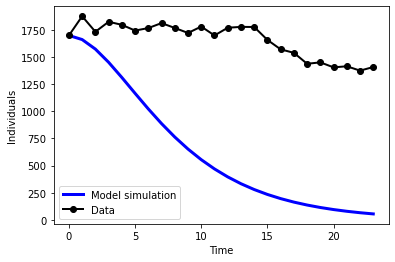

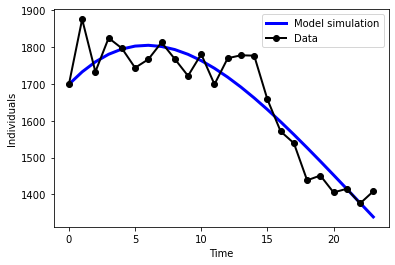

3
[[ 1.54972742e+07 -3.32692814e+07  2.67224375e+02]
 [-3.32692814e+07  1.49192326e+08  1.17722779e+03]
 [ 2.67224375e+02  1.17722779e+03  4.42308088e-02]]
Starting profile...
0 0.13210732374258966
0 0.12843767586085106
0 0.12476802797911245
0 0.12109838009737385
0 0.11742873221563525
0 0.11375908433389664
0 0.11008943645215805
0 0.10641978857041945
0 0.10275014068868084
0 0.09908049280694224
1 0.13577697162432825
1 0.13944661950606685
1 0.14311626738780545
1 0.14678591526954404
1 0.15045556315128267
1 0.15412521103302126
1 0.15779485891475986
1 0.16146450679649846
1 0.16513415467823706
['gamma', 'k']
[0.04249466473678935, 3314.187152459228]
Starting profile...
0 0.04249466473678935
0 0.04131425738298965
0 0.04013385002918994
0 0.03895344267539024
0 0.037773035321590535
0 0.03659262796779083
0 0.03541222061399112
0 0.034231813260191424
0 0.03305140590639172
0 0.03187099855259201
1 0.04367507209058906
1 0.044855479444388766
1 0.046035886798188465
1 0.04721629415198817
1 0.04839670150578

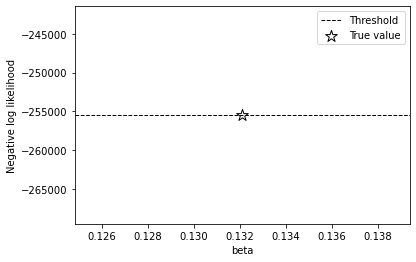

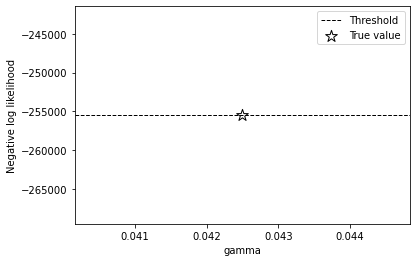

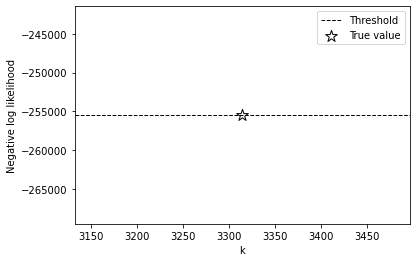

In [11]:
#### Load Data ####
# times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
# data = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]
times = np.linspace(0, 23, 24)
data = [1699,
 1876,
 1733,
 1825,
 1797,
 1744,
 1767,
 1813,
 1768,
 1722,
 1781,
 1699,
 1770,
 1778,
 1777,
 1658,
 1571,
 1539,
 1438,
 1451,
 1405,
 1415,
 1375,
 1408]

#shortened version for seeing how truncated data affects the estimation
#times = times[0:7]
#data = data[0:7]

#### Set initial parameter values and initial states ####
params = [0.4, 0.25, 4397]#make sure all the params and inition states are float
paramnames = ['beta', 'gamma', 'k']
ini = x0fcn(params,data)
print(ini)

#### Simulate and plot the model ####
res = ode(model, ini, times, args=(params,))
print(res)
sim_measure = yfcn(res, params)
print(sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()


#### Parameter estimation ####
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, data)

#### Re-simulate and plot the model with the final parameter estimates ####
xest = ode(model, iniests, times, args=(paramests,))
est_measure = yfcn(xest, paramests)
plt.plot(times, est_measure, 'b-', linewidth=3, label='Model simulation')
plt.plot(times, data, 'k-o', linewidth=2, label='Data')
plt.xlabel('Time')
plt.ylabel('Individuals')
plt.legend()
plt.show()

#### Calculate the simplified Fisher Information Matrix (FIM) ####
FIM = minifisher(times, params, data, delta = 0.001)
print(np.linalg.matrix_rank(FIM)) #calculate rank of FIM
print(FIM)

#### Generate profile likelihoods and confidence bounds ####
threshold = stats.chi2.ppf(0.95,len(paramests))/2.0 + optimizer.fun
perrange = 0.25 #percent range for profile to run across

profiles={}
for i in range(len(paramests)):
    profiles[paramnames[i]] = proflike(paramests, i, NLL, times, data, perrange=perrange)
    plt.figure()
    plt.scatter(paramests[i], optimizer.fun, marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
    # plt.plot(profiles[paramnames[i]]['profparam'], profiles[paramnames[i]]['fcnvals'], 'k-', linewidth=2, label='Profile likelihood')
    plt.axhline(y=threshold, ls='--',linewidth=1.0, label='Threshold', color='k')
    plt.xlabel(paramnames[i])
    plt.ylabel('Negative log likelihood')
    plt.legend(scatterpoints = 1)
    paramnames_fit = [ n for n in paramnames if n not in [paramnames[i]]]
    paramests_fit = [v for v in paramests if v not in [paramests[i]]]
    print(paramnames_fit)
    print(paramests_fit)

    #plot parameter relationships
    # for j in range(profiles[paramnames[i]]['fitparam'].shape[1]):
    #     plt.figure()
    #     plt.plot(profiles[paramnames[i]]['profparam'],profiles[paramnames[i]]['fitparam'][:,j],'k-', linewidth=2, label=paramnames_fit[j])
    #     plt.scatter(paramests[i], paramests_fit[j], marker='*',label='True value', color='k',s=150, facecolors='w', edgecolors='k')
    #     plt.xlabel(paramnames[i])
    #     plt.ylabel(paramnames_fit[j])
    plt.legend(scatterpoints = 1)
print(profiles)
plt.show()


In [13]:
paramnames_fit

['beta', 'gamma']

In [14]:
paramests_fit

[0.13210732374258966, 0.04249466473678935]